# Data Preparation

In [2]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, auc, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.missing_ipywidgets import FigureWidget
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

import seaborn as sns
import missingno as msno


from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

from imblearn.over_sampling import SMOTE
import statsmodels.formula.api as smf

#import featuretools as ft

import tensorflow as tf

In [4]:
def read_and_set_df(filepath: str, train: bool) -> pd.DataFrame:

    # with open(filepath) as file:
    # file.readlines()

    # Datensatz einlesen
    df = pd.read_csv(filepath, sep='$',  # r'([$-,])+/g'
                     decimal=".", engine='python')  # , na_values=[np.nan, pd.NA], keep_default_na=True)

    # Spaltennamen alle kleingeschrieben
    df.columns = df.columns.str.lower()

    # Die Spaltennamen waren verschoben - In diesem Schritt werden sie richtig zugeordnet
    df.rename(columns={
        'unnamed: 0': 'id',
        'id': 'gender',
        'gender': 'age',
        'age': 'driving_license',
        'driving_license': 'region_code',
        'region_code': 'previously_insured',
        'previously_insured': 'vehicle_age',
        'vehicle_age': 'vehicle_damage',
        'vehicle_damage': 'annual_premium',
        'annual_premium': 'policy_sales_channel',
        'policy_sales_channel': 'vintage',
        'vintage': 'response',
        'response': 'nan'
    },
        inplace=True)

    # Letzte Spalte besteht nur aus nan und kann somit gelöscht werden
    if not train:
        del df['nan']

    return df


def set_datatypes(df: pd.DataFrame) -> pd.DataFrame:

    # Numerische Variablen
    # Nullable Interger

    # Variable Age
    df["age"] = df["age"].astype(str)
    df["age"] = df["age"].str.rstrip('.')
    df['age'] = df["age"].replace('nan', np.nan)
    df['age'] = pd.to_numeric(df['age'], errors='raise')
    df["age"] = df["age"].astype('Int64')

    # Annual Premium
    df['annual_premium'] = df['annual_premium'].astype(str)
    df['annual_premium'] = df['annual_premium'].str.rstrip('.')
    df["annual_premium"] = pd.to_numeric(df["annual_premium"], errors='raise')
    df["annual_premium"] = df["annual_premium"].astype('Int64')

    # Vintage
    df['vintage'] = df['vintage'].astype(str)
    df['vintage'] = df['vintage'].str.rstrip('##')
    df['vintage'] = df["vintage"].replace('nan', np.nan)
    df["vintage"] = pd.to_numeric(df["vintage"], errors='raise')
    df["vintage"] = df["vintage"].astype('Int64')

    # Region Code
    df['region_code'] = df['region_code'].astype(str)
    df['region_code'] = df['region_code'].str.rstrip('#')
    df["region_code"] = pd.to_numeric(df["region_code"], errors='raise')
    df['region_code'] = df['region_code'].astype('category')

    # Policy Sales Channel
    df['policy_sales_channel'] = df['policy_sales_channel'].astype(str)
    df['policy_sales_channel'] = df['policy_sales_channel'].str.rstrip('##')
    df["policy_sales_channel"] = pd.to_numeric(
        df["policy_sales_channel"], errors='raise')
    df["policy_sales_channel"] = df["policy_sales_channel"].astype('Int64')

    # Kategorische Variablen
    df['gender'] = df['gender'].astype('category')
    df['driving_license'] = df['driving_license'].astype('category')
    df['previously_insured'] = df['previously_insured'].astype('category')
    df['vehicle_damage'] = df['vehicle_damage'].astype('category')
    df['vehicle_age'] = df['vehicle_age'].astype('category')

    # Response
    df.response.replace(
        {'0': 'no', '1': 'yes', 1: 'yes', 0: 'no'}, inplace=True)
    df['response'] = df['response'].astype('category')

    #df = df.replace(to_replace=['NaN', '<NA>', 'NAN', 'nan',
    #                pd.NA, np.nan, np.NaN, np.NAN], value=np.NaN, inplace=True)

    return df

In [5]:
df = read_and_set_df('../data/train.csv', train=False)

set_datatypes(df)

df.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,No,28.0,No,> 2 Years,Yes,40454,26,217,yes
1,2,Male,76,No,3.0,No,1-2 Year,No,33536,26,183,no
2,3,Male,47,No,28.0,No,> 2 Years,Yes,38294,26,27,yes
3,4,Male,21,Yes,11.0,Yes,< 1 Year,No,28619,152,203,no
4,5,Female,29,Yes,41.0,Yes,< 1 Year,No,27496,152,39,no


In [6]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,380999.0,NaN,NaN,NaN,190500.0,109985.081943,1.0,95250.5,190500.0,285749.5,380999.0
gender,379948,2,Male,205447,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,370107.0,NaN,NaN,NaN,38.852091,15.63218,20.0,25.0,36.0,49.0,205.0
driving_license,380948,2,No,206635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_code,380999.0,53.0,28.0,106372.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previously_insured,380948,2,No,206635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle_age,380948,3,1-2 Year,200228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle_damage,380948,2,Yes,192328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_premium,380999.0,NaN,NaN,NaN,30527.70069,17242.997675,-9997.0,24371.0,31656.0,39390.0,540165.0
policy_sales_channel,380999.0,NaN,NaN,NaN,112.035331,54.203334,1.0,29.0,133.0,152.0,163.0


## Missing Values

Die Funktion `heatmap()` von `missingno` misst die Nullkorrelation: wie stark das Vorhandensein oder Fehlen einer Variable das Vorhandensein einer anderen Variable beeinflusst.

Die Nullkorrelation reicht von -1 (wenn eine Variable auftritt, tritt die andere definitiv nicht auf) über 0 (auftauchende oder nicht auftauchende Variablen haben keinen Einfluss aufeinander) bis 1 (wenn eine Variable auftritt, tritt die andere definitiv auf).


### Verteilung der Missing Values 

<AxesSubplot:>

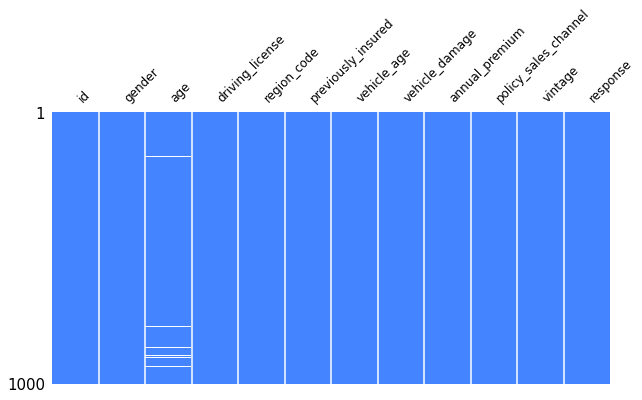

In [7]:
# Verteilung der Missing Values innerhalb der Variablen 
msno.matrix(df.sample(1000), sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0))

<AxesSubplot:>

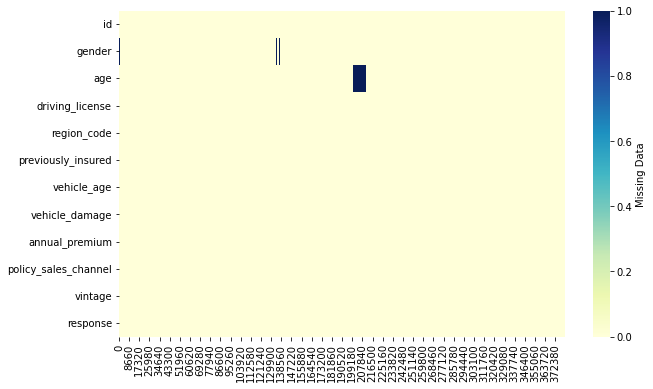

In [8]:

plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})


<AxesSubplot:>

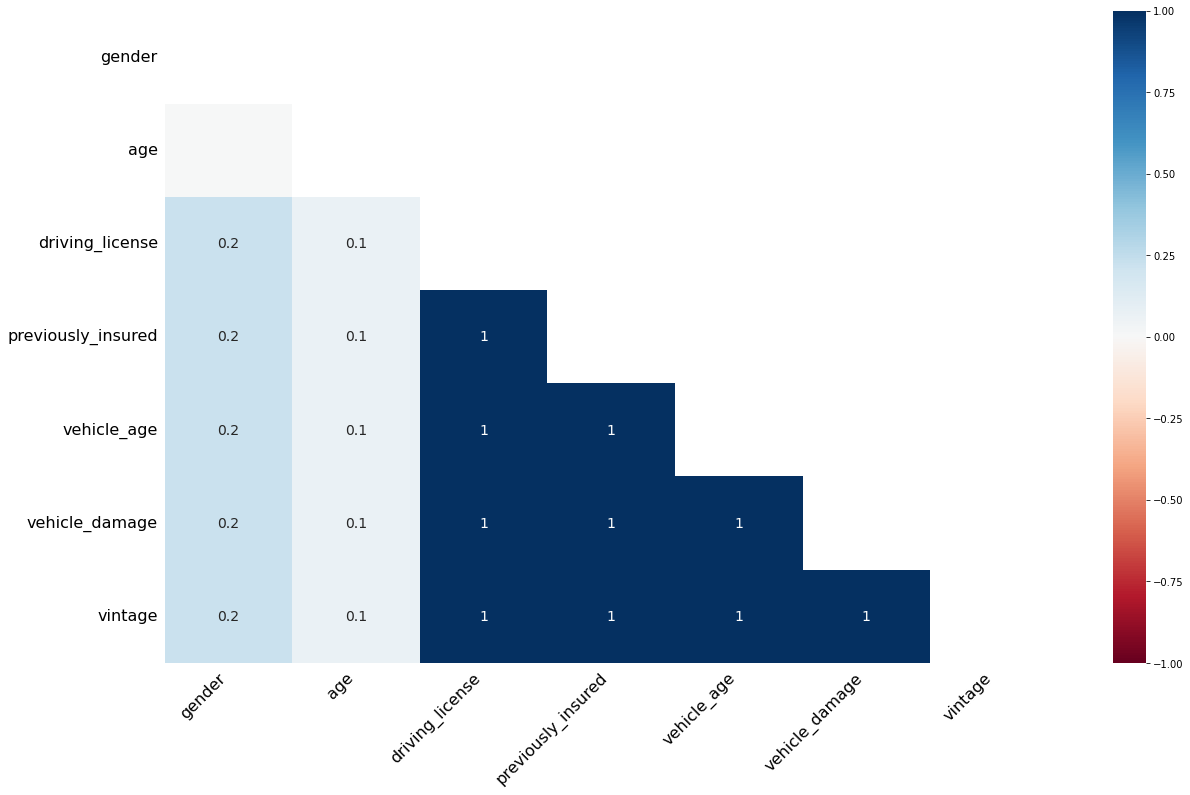

In [9]:
# Visualize the correlation between the number of
# missing values in different columns as a heatmap
msno.heatmap(df)



Um dieses Diagramm zu interpretieren, lesen Sie es aus einer Top-Down-Perspektive. Clusterblätter, die in einem Abstand von Null miteinander verbunden sind, sagen das Vorhandensein des jeweils anderen vollständig voraus - eine Variable könnte immer leer sein, wenn eine andere gefüllt ist, oder sie könnten immer beide gefüllt oder beide leer sein, und so weiter. In diesem speziellen Beispiel klebt das Dendrogramm die Variablen zusammen, die erforderlich und daher in jedem Datensatz vorhanden sind.

Clusterblätter, die sich in der Nähe von Null aufspalten, aber nicht bei Null, sagen sich gegenseitig sehr gut, aber immer noch unvollkommen voraus. Wenn Ihre eigene Interpretation des Datensatzes darin besteht, dass diese Spalten tatsächlich in Null übereinstimmen oder übereinstimmen sollten (z. B. als BETEILIGUNGSFAKTOR FAHRZEUG 2 und FAHRZEUG-TYPCODE 2), dann sagt Ihnen die Höhe des Clusterblatts in absoluten Zahlen, wie oft die Datensätze "nicht übereinstimmen" oder falsch abgelegt sind - d. h. wie viele Werte Sie ausfüllen oder streichen müssten, wenn Sie dazu geneigt sind.

Beschreibung: 
Das Dendrogramm verwendet einen hierarchischen Clustering-Algorithmus, um die Variablen anhand ihrer Nullkorrelation gegeneinander abzugrenzen. 


Erklärung: 
Clutster, die sich in bei Null aufspalten, sagen sich untereinander vollkommen voraus (Korrelation von 1). Auf Grundlage 

Auf jeder Stufe des Baums werden die Variablen auf der Grundlage der Kombination aufgeteilt, die den Abstand der verbleibenden Cluster minimiert.  

Je monotoner die Variablen sind, desto näher liegt ihr Gesamtabstand bei Null und desto näher liegt ihr durchschnittlicher Abstand (die y-Achse) bei Null.   

<AxesSubplot:>

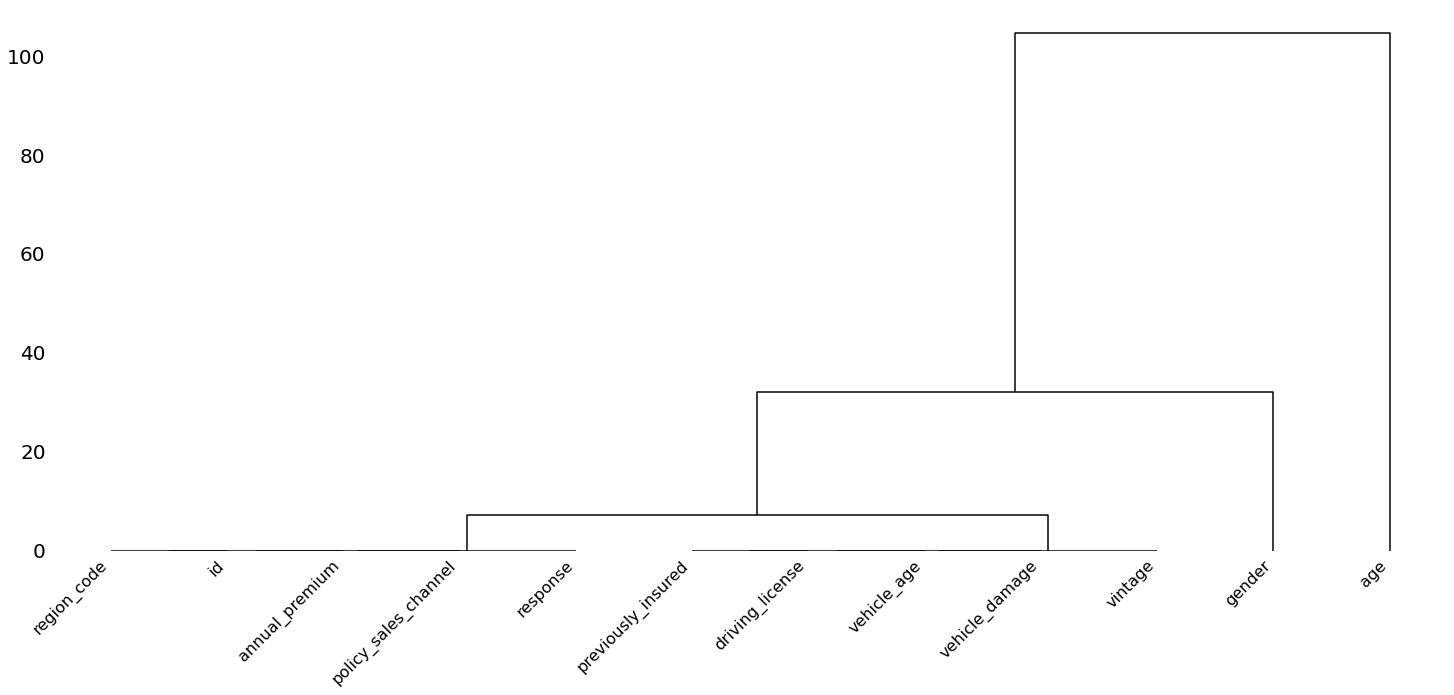

In [10]:
msno.dendrogram(df, orientation='top')

In [11]:
df_na_bool = pd.DataFrame(pd.isna(df))

df.drop(df_na_bool[(df_na_bool['previously_insured'] == True) & 
           (df_na_bool['driving_license'] == True) &
           (df_na_bool['vehicle_age'] == True) &
           (df_na_bool['vehicle_damage'] == True) &
           (df_na_bool['vintage'] == True)].index, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380948 entries, 0 to 380998
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   id                    380948 non-null  int64   
 1   gender                379948 non-null  category
 2   age                   370107 non-null  Int64   
 3   driving_license       380948 non-null  category
 4   region_code           380948 non-null  category
 5   previously_insured    380948 non-null  category
 6   vehicle_age           380948 non-null  category
 7   vehicle_damage        380948 non-null  category
 8   annual_premium        380948 non-null  Int64   
 9   policy_sales_channel  380948 non-null  Int64   
 10  vintage               380948 non-null  Int64   
 11  response              380948 non-null  category
dtypes: Int64(4), category(7), int64(1)
memory usage: 21.4 MB


In [12]:
pd.isna(df).sum()

id                          0
gender                   1000
age                     10841
driving_license             0
region_code                 0
previously_insured          0
vehicle_age                 0
vehicle_damage              0
annual_premium              0
policy_sales_channel        0
vintage                     0
response                    0
dtype: int64

Listenweiser Fallausschluss - Wir haben mittels dem listenweisen Fallausschluss 51 Zeilen aus dem Datensatz entfernt. Dabei haben wir ebenfalls die Anzahl der missing values bei den Variablen von age und gender um 51 Werte reduziert.

## Behandlung von Anomalien

### Age

- Untergrenze: 18
- Obergrenze: 100

In [13]:
index_max_age = df[df["age"] >= 100].index
df.drop(index_max_age, inplace=True)

index_min_age = df[df["age"] < 18].index
df.drop(index_min_age, inplace=True)

df["age"].describe()

count    370007.000000
mean         38.820579
std          15.509008
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: age, dtype: float64

### Annual Premium

- Untergrenze: 0

In [14]:
index_min_premium = df[df["annual_premium"] <= 0].index
df.drop(index_min_premium, inplace=True)

df["annual_premium"].describe()

count    380481.000000
mean      30562.388193
std       17213.199244
min        2630.000000
25%       24403.000000
50%       31667.000000
75%       39400.000000
max      540165.000000
Name: annual_premium, dtype: float64

## Train Test Splitting

In [15]:
X = df.drop(['response', 'id'], axis=1)
y = df[['response']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=42)

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

len(X_train_df), len(y_train_df), len(X_test_df), len(y_test_df)

(304384, 304384, 76097, 76097)

In [16]:
y_test.head()

,response
257536,no
206457,no
135947,no
299033,no
325473,no


#### Categorial Mapping

In [17]:
def map_categorials_x(df):


    LE = LabelEncoder()
    df['driving_license'] = LE.fit_transform(df.loc[:, 'driving_license'])
    df['previously_insured'] = LE.fit_transform(df.loc[:, 'previously_insured'])
    df['vehicle_age'] = LE.fit_transform(df.loc[:, 'vehicle_age'])
    df['vehicle_damage'] = LE.fit_transform(df.loc[:, 'vehicle_damage'])
    df['region_code'] = LE.fit_transform(df.loc[:,'region_code'])
    df['gender'] = LE.fit_transform(df.loc[:, 'gender'])

    return df

X_train_label_encoded = map_categorials_x(X_train_df.copy())
X_test_label_encoded = map_categorials_x(X_test_df.copy())

def map_categorials_y(df):
    LE = LabelEncoder()

    df['response'] = LE.fit_transform(df.loc[:,'response'])

    return df

y_train_label_encoded = map_categorials_y(y_train_df.copy())
y_test_label_encoded = map_categorials_y(y_test_df.copy())

ONE HOT encoding:

ONE-HOT-ENCODiNG transformiert kategoriale Variablen zu binären Variablen mittels des 'one-hot' Verfahrens.
Dieser Schritt der Kodierung kategorialer Variablen ist nötig, um diese später in linearen Modellen und Vektor Maschinen zu verwenden.

In [76]:
X_train_df_one_hot_encoded_data_without_gender = pd.get_dummies(X_train_df, columns = ['driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured'])

X_test_df_one_hot_encoded_data_without_gender = pd.get_dummies(X_test_df, columns = ['driving_license', 'vehicle_age', 'vehicle_damage', 'previously_insured'])

X_train_df_one_hot_encoded_data_without_gender.head()

,gender,age,region_code,annual_premium,policy_sales_channel,vintage,driving_license_No,driving_license_Yes,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes,previously_insured_No,previously_insured_Yes
263106,Male,60,46.0,38364,26,154,0,1,1,0,0,1,0,0,1
135199,Male,50,43.0,2630,124,99,1,0,1,0,0,0,1,1,0
201773,Male,<NA>,28.0,55674,26,97,1,0,1,0,0,1,0,1,0
112318,Male,42,28.0,29181,124,93,1,0,1,0,0,0,1,1,0
158346,Male,40,28.0,38652,15,198,1,0,1,0,0,0,1,1,0


## Imputationverfahren für die Variable Age

### Imputation auf der Train Batch

usprüngliche Verteilung vom Alter bei der Train und Test Batch

In [20]:
X_train_original_age = pd.DataFrame(X_train_df['age'].dropna(), columns=['age'])
X_test_original_age = pd.DataFrame(X_test_df['age'].dropna(), columns=['age'])

#### Mean Imputation 

In [21]:
# Fill missing values of Age with the average of Age (mean)
X_test_mean = pd.DataFrame(X_test_df['age'].fillna(round(X_test_df['age'].mean(),0)).astype("Int64"), columns=['age'])
X_train_mean = pd.DataFrame(X_train_df['age'].fillna(round(X_train_df['age'].mean(),0)).astype("Int64"), columns=['age'])

#### Median Imputation 

In [22]:
# Fill missing values of Age with the average of Age (median)
X_test_median = pd.DataFrame(X_test_df['age'].fillna(round(X_test_df['age'].mean(),0)).astype("Int64"), columns=['age'])
X_train_median = pd.DataFrame(X_train_df['age'].fillna(round(X_train_df['age'].median(),0)).astype("Int64"), columns=['age'])

#### K-Nearest Neighbour

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

# results = list()
# strategies = [str(i) for i in [1,3,5,7,9,15,18,21]]
# for s in strategies:
# 	# create the modeling pipeline
# 	pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
# 	# evaluate the model
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# 	scores = cross_val_score(pipeline, X_train_label_encoded, y_train_label_encoded, scoring='accuracy', cv=cv, n_jobs=-1)
# 	# store results
# 	results.append(scores)
# 	print('>%s %.3f (%.3f)' % (s, np.mean(scores), np.std(scores)))
# # plot model performance for comparison
# plt.boxplot(results, labels=strategies, showmeans=True)
# plt.show()

In [81]:
knn = KNNImputer(n_neighbors=7, weights='uniform')

# Modellierung auf Trainingsdaten
X_train_df_knn_X = X_train_df_one_hot_encoded_data_without_gender.copy().replace({'Female': 0, 'Male': 1})

X_knn_train = knn.fit_transform(X_train_df_knn_X)
X_train_df_knn = pd.DataFrame(X_knn_train, columns=X_train_df_knn_X.columns)

# Modellierung auf Testdaten
X_test_df_knn_X = X_test_df_one_hot_encoded_data_without_gender.copy().replace({'Female': 0, 'Male': 1})

X_knn_test = np.round(knn.fit_transform(X_test_df_knn_X))
X_test_df_knn = pd.DataFrame(X_knn_test, columns=X_test_df_knn_X.columns)

X_train_df_knn['gender'] = X_train_df_knn['gender'].round().replace({0: 'Female', 1: 'Male'})
X_test_df_knn['gender'] = X_test_df_knn['gender'].round().replace({0: 'Female', 1: 'Male'})

,gender,age,region_code,annual_premium,policy_sales_channel,vintage,driving_license_No,driving_license_Yes,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes,previously_insured_No,previously_insured_Yes
0,Male,60.000000,46.0,38364.0,26.0,154.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,Male,50.000000,43.0,2630.0,124.0,99.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,Male,59.714286,28.0,55674.0,26.0,97.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Male,42.000000,28.0,29181.0,124.0,93.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,Male,40.000000,28.0,38652.0,15.0,198.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


<AxesSubplot:>

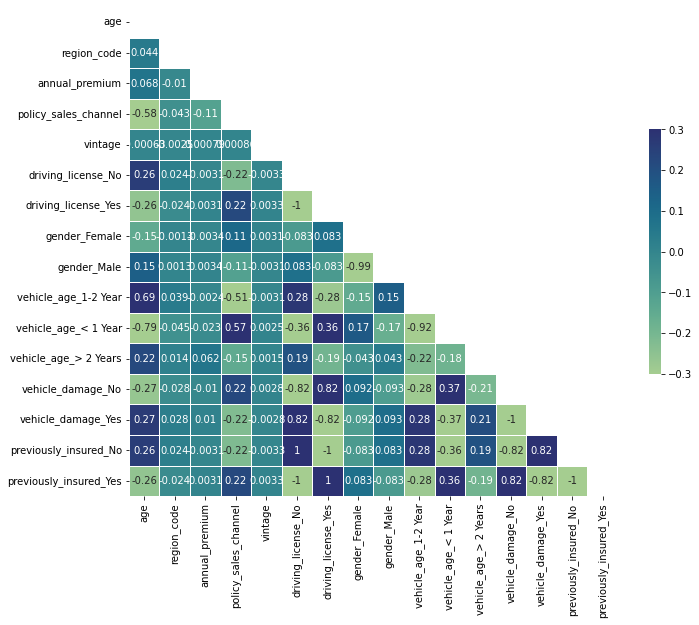

In [25]:
# Create the correlation matrix
corr = X_train_df_knn.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("crest", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)

In [26]:
X_train_label_encoded['age'].unique()

<IntegerArray>
[  60,   50, <NA>,   42,   40,   38,   29,   30,   57,   26,   24,   36,   41,
   71,   21,   23,   56,   25,   52,   22,   45,   69,   35,   27,   61,   49,
   72,   80,   31,   51,   77,   58,   48,   20,   44,   64,   54,   33,   46,
   65,   43,   47,   32,   37,   28,   74,   79,   55,   78,   66,   63,   39,
   76,   34,   53,   68,   59,   67,   73,   62,   70,   75,   81,   82,   83,
   84,   85]
Length: 67, dtype: Int64

#### Miss Forest

In [27]:
from sklearn.experimental import enable_iterative_imputer

# Modellierung auf den Trainingsdaten
X_train_df_mice_X = X_train_df_one_hot_encoded_data.copy()

mice_imputer = IterativeImputer()
X_mice = mice_imputer.fit_transform(X_train_df_mice_X)
X_train_df_mice = pd.DataFrame(X_mice, columns=X_train_df_mice_X.columns)
X_train_df_mice['age'] = X_train_df_mice['age'].round()

# Modellierung auf den Testdaten
X_test_df_mice_X = X_test_df_one_hot_encoded_data.copy()

X_mice = mice_imputer.fit_transform(X_test_df_mice_X)
X_test_df_mice = pd.DataFrame(X_mice, columns=X_test_df_mice_X.columns)
X_test_df_mice['age'] = X_test_df_mice['age'].round()

#### Lineares Regressionsmodell

In [28]:
X_train_df_one_hot_encoded_data.isna().sum()

age                       8701
region_code                  0
annual_premium               0
policy_sales_channel         0
vintage                      0
driving_license_No           0
driving_license_Yes          0
gender_Female                0
gender_Male                  0
vehicle_age_1-2 Year         0
vehicle_age_< 1 Year         0
vehicle_age_> 2 Years        0
vehicle_damage_No            0
vehicle_damage_Yes           0
previously_insured_No        0
previously_insured_Yes       0
dtype: int64

In [29]:
# Train-Batch Datensatz filtern, nach allen Zeilen mit Missing Values bei Age
X_train_age_na = X_train_df_one_hot_encoded_data['age'].isna()
X_train_age_missing = X_train_age_na[X_train_age_na == True]
X_train_age_missing = pd.merge(X_train_age_missing, X_train_df_one_hot_encoded_data, left_index=True, right_index=True)
del X_train_age_missing['age_y']
del X_train_age_missing['age_x']

# Test-Batch Datensatz filtern, nach allen Zeilen mit Missing Values bei Age
X_test_age_na = X_test_df_one_hot_encoded_data['age'].isna()
X_test_age_missing = X_test_age_na[X_test_age_na == True]
X_test_age_missing = pd.merge(X_test_age_missing, X_test_df_one_hot_encoded_data, left_index=True, right_index=True)
del X_test_age_missing['age_y']
del X_test_age_missing['age_x']

# Länge der beiden Data Frames ausgeben lassen
print(len(X_train_age_missing), len(X_test_age_missing))

8701 2140


In [30]:
X_train_df_one_hot_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304384 entries, 263106 to 122074
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   age                     295683 non-null  Int64   
 1   region_code             304384 non-null  category
 2   annual_premium          304384 non-null  Int64   
 3   policy_sales_channel    304384 non-null  Int64   
 4   vintage                 304384 non-null  Int64   
 5   driving_license_No      304384 non-null  uint8   
 6   driving_license_Yes     304384 non-null  uint8   
 7   gender_Female           304384 non-null  uint8   
 8   gender_Male             304384 non-null  uint8   
 9   vehicle_age_1-2 Year    304384 non-null  uint8   
 10  vehicle_age_< 1 Year    304384 non-null  uint8   
 11  vehicle_age_> 2 Years   304384 non-null  uint8   
 12  vehicle_damage_No       304384 non-null  uint8   
 13  vehicle_damage_Yes      304384 non-null  uint8   
 14 

In [31]:


# Casting für die Training-Batch
X_train_df_one_hot_encoded_data_no_na = X_train_df_one_hot_encoded_data.copy().dropna()
X_train_df_one_hot_encoded_data_no_na['annual_premium']= X_train_df_one_hot_encoded_data_no_na['annual_premium'].astype(int)
X_train_df_one_hot_encoded_data_no_na['vintage'] = X_train_df_one_hot_encoded_data_no_na['vintage'].astype(int)
X_train_df_one_hot_encoded_data_no_na['policy_sales_channel'] = X_train_df_one_hot_encoded_data_no_na['policy_sales_channel'].astype(int)
X_train_df_one_hot_encoded_data_no_na['age'] = X_train_df_one_hot_encoded_data_no_na['age'].astype(int)

# Casting für die Testing-Batch
X_test_df_one_hot_encoded_data_no_na = X_test_df_one_hot_encoded_data.copy().dropna()
X_test_df_one_hot_encoded_data_no_na['annual_premium']= X_test_df_one_hot_encoded_data_no_na['annual_premium'].astype(int)
X_test_df_one_hot_encoded_data_no_na['vintage'] = X_test_df_one_hot_encoded_data_no_na['vintage'].astype(int)
X_test_df_one_hot_encoded_data_no_na['policy_sales_channel'] = X_test_df_one_hot_encoded_data_no_na['policy_sales_channel'].astype(int)
X_test_df_one_hot_encoded_data_no_na['age'] = X_test_df_one_hot_encoded_data_no_na['age'].astype(int)

# Modell aufbauen
def smf_ols_spec(df): 
    mod = smf.ols(formula = 'age ~ annual_premium + policy_sales_channel + gender_Male + vehicle_damage_No + vehicle_damage_Yes + previously_insured_No + previously_insured_Yes', data=X_train_df_one_hot_encoded_data_no_na)
    return mod

ols_train = smf_ols_spec(X_train_df_one_hot_encoded_data_no_na)
ols_test = smf_ols_spec(X_test_df_one_hot_encoded_data_no_na)

# modell auf den Trainingsdaten fitten
res_train = ols_train.fit()
res_test = ols_test.fit()

In [32]:
# Resultate für die Training-Batch ausgeben lassen 
print(res_train.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                 3.323e+04
Date:                Mon, 17 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:54:13   Log-Likelihood:            -1.1642e+06
No. Observations:              295683   AIC:                         2.328e+06
Df Residuals:                  295677   BIC:                         2.329e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 27

In [33]:
# Resultate für die Training-Batch ausgeben lassen 
print(res_test.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                 3.323e+04
Date:                Mon, 17 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:54:13   Log-Likelihood:            -1.1642e+06
No. Observations:              295683   AIC:                         2.328e+06
Df Residuals:                  295677   BIC:                         2.329e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 27

In [34]:
# Hier müssen wir die für die Regression verwendeten Variablen nochmal casten, um diese auch im Modell verwenden zu können
X_train_age_missing['annual_premium']= X_train_age_missing['annual_premium'].astype(int)
X_train_age_missing['vintage'] = X_train_age_missing['vintage'].astype(int)
X_train_age_missing['policy_sales_channel'] = X_train_age_missing['policy_sales_channel'].astype(int)

# Predicten 
predictions_age_train_data_ols = pd.DataFrame(round(res_train.predict(X_train_age_missing),2))
predictions_age_train_data_ols.columns = ['age']
predictions_age_train_data_ols

,age
201773,52.40
201299,40.92
200551,55.37
210040,33.18
202852,33.73
...,...
208779,35.70
201069,38.00
208142,27.95
205559,40.26


In [35]:
# Hier müssen wir die für die Regression verwendeten Variablen nochmal casten, um diese auch im Modell verwenden zu können
X_test_age_missing['annual_premium']= X_test_age_missing['annual_premium'].astype(int)
X_test_age_missing['vintage'] = X_test_age_missing['vintage'].astype(int)
X_test_age_missing['policy_sales_channel'] = X_test_age_missing['policy_sales_channel'].astype(int)

# Predicten 
predictions_age_test_data_ols = pd.DataFrame(round(res_test.predict(X_test_age_missing),2))
predictions_age_test_data_ols.columns = ['age']
predictions_age_test_data_ols

,age
206457,28.93
202211,30.09
205321,27.85
210196,55.37
208254,40.34
...,...
201110,31.34
201844,27.70
207109,40.33
202773,29.07


In [36]:
# Training-Batch
X_train_df_regression = pd.merge(X_train_age_missing, predictions_age_train_data_ols, right_index=True, left_index=True)
X_train_df_regression = X_train_df_regression.combine_first(X_train_df_one_hot_encoded_data)

# Training-Batch
X_test_df_regression = pd.merge(X_test_age_missing, predictions_age_test_data_ols, right_index=True, left_index=True)
X_test_df_regression = X_test_df_regression.combine_first(X_test_df_one_hot_encoded_data)

X_train_df_regression

,age,annual_premium,driving_license_No,driving_license_Yes,gender_Female,gender_Male,policy_sales_channel,previously_insured_No,previously_insured_Yes,region_code,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes,vintage
0,44.0,40454,1,0,0,1,26,1,0,28.0,0,0,1,0,1,217
1,76.0,33536,1,0,0,1,26,1,0,3.0,1,0,0,1,0,183
3,21.0,28619,0,1,0,1,152,0,1,11.0,0,1,0,1,0,203
4,29.0,27496,0,1,1,0,152,0,1,41.0,0,1,0,1,0,39
5,24.0,2630,1,0,1,0,160,1,0,33.0,0,1,0,0,1,176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380992,76.0,27309,1,0,0,1,124,1,0,43.0,1,0,0,0,1,17
380993,63.0,2630,1,0,0,1,124,1,0,28.0,0,0,1,0,1,61
380995,46.0,51660,1,0,0,1,124,1,0,28.0,1,0,0,0,1,227
380996,28.0,26431,0,1,1,0,152,0,1,50.0,0,1,0,1,0,43


#### Visualisierung der Imputationsverfahren in der Train Batch

In [118]:
hist_data_train = [np.array(X_train_df_regression['age'], dtype=np.int64), np.array(X_train_df_mice['age'], dtype=np.int64), np.array(X_train_df_knn['age'], dtype=np.int64), np.array(X_train_mean['age'], dtype=np.int64), np.array(X_train_median['age'], dtype=np.int64), np.array(X_train_original_age['age'], dtype=np.int64)]

group_labels = ['train_imputed_regression', 'train_imputed_mice_age','train_imputed_knn_age','train_imputed_mean_age', 'train_imputed_median_age', 'actual_df_age']
colors = ['red','#333F44', '#37AA9C', '#f3722c', '#6a994e', '#0077b6']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data_train, group_labels, show_hist=False, colors=colors, rug_text=None, show_rug=False)

fig.update_layout(legend=dict(x=0.893,y=1,traceorder="reversed",title_font_family="Times New Roman",font=dict(family="Courier",size=12,color="black"),bgcolor="LightSteelBlue",bordercolor="#fff",borderwidth=2))

# Add title
fig.update_layout(title_text='Verteilung der Variable age nach der Imputation in der Train Batch')
fig.show()

### Visualisierung der Imputationsverfahren auf der Test Batch 

In [115]:
hist_data_test = [np.array(X_train_df_regression['age'], dtype=np.int64), np.array(X_test_df_mice['age'], dtype=np.int64), np.array(X_test_df_knn['age'], dtype=np.int64), np.array(X_test_mean['age'], dtype=np.int64), np.array(X_test_median['age'], dtype=np.int64), np.array(X_test_original_age['age'], dtype=np.int64)]

group_labels = ['test_imputed_ols_age','test_imputed_mice_age','test_imputed_knn_age','test_imputed_mean_age', 'test_imputed_median_age', 'actual_df_age']
colors = ['red', '#333F44', '#37AA9C', '#f3722c', '#6a994e', '#0077b6']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data_test, group_labels, show_hist=False, colors=colors, rug_text=None, show_rug=False)
fig.update_layout(legend=dict(x=0.895,y=1,traceorder="reversed",title_font_family="Times New Roman",font=dict(family="Courier",size=12,color="black"),bgcolor="LightSteelBlue",bordercolor="#fff",borderwidth=2))

# Add title
fig.update_layout(title_text='Verteilung der Variable age nach der Imputation in der Test Batch')
fig.show()

#### Visualisierung der Impuation von gender

In [109]:
print(X_train_df['gender'].value_counts(normalize=True))
print('-'*30)
print(X_train_df_knn['gender'].value_counts(normalize=True))

Male      0.541157
Female    0.458843
Name: gender, dtype: float64
------------------------------
Male      0.541244
Female    0.458756
Name: gender, dtype: float64


In [120]:
X_train_df_one_hot_encoded_data = pd.get_dummies(X_train_df_one_hot_encoded_data_without_gender, columns = ['gender'])

X_test_df_one_hot_encoded_data = pd.get_dummies(X_test_df_one_hot_encoded_data_without_gender, columns = ['gender'])

## Sampling

#### Oversampling

In [41]:
X_train_df_os = pd.concat([X_train_df,y_train_df],axis=1)

response_no = X_train_df_os[X_train_df_os['response'] == 'no']
response_yes = X_train_df_os[X_train_df_os['response'] == 'yes']

# upsample minority
response_upsampled = resample(response_yes,
                          replace=True, # sample with replacement
                          n_samples=len(response_no), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([response_no, response_upsampled])

# check new class counts
upsampled.response.value_counts()

no     267089
yes    267089
Name: response, dtype: int64

In [42]:
df_upsampled_response = upsampled.groupby(['response']).size().reset_index()
fig = px.bar(df_upsampled_response, x='response', y=upsampled['response'].value_counts(normalize=False), color='response',
                                    text=upsampled['response'].value_counts(normalize=False),
                                    color_discrete_map={
                                        'yes': 'rgb(18,116,117)',
                                        'no': 'rgb(20,29,67)'
                                    })

fig.update_layout(title='Relative Verteilung der Ausprägungen von Response nach dem Upsampling',
                 xaxis_title='Response',
                 yaxis_title='Count')
fig.show()

#### Undersampling mit einem einfachen Modell evaluieren 

In [43]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='auto')

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train_df_knn, y_train_label_encoded['response'])
X_test_under, y_test_under = undersample.fit_resample(X_test_df_knn, y_test_label_encoded['response'])

# summarize class distribution
print("Before undersampling train: ", Counter(y_train_label_encoded['response']))
print("After undersampling train: ", Counter(y_train_under))

print('-'*60)
# summarize class distribution
print("Before undersampling test: ", Counter(y_test_label_encoded['response']))
print("After undersampling test: ", Counter(y_test_under))


from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

model = SVC()
clf_under = model.fit(X_train_under, y_train_under)
pred_under = clf_under.predict(X_test_df_knn)


print('-'*60)
print("ROC AUC score for undersampled data: ", roc_auc_score(y_test_label_encoded, pred_under))

Before undersampling train:  Counter({0: 267089, 1: 37295})
After undersampling train:  Counter({0: 37295, 1: 37295})
------------------------------------------------------------
Before undersampling test:  Counter({0: 66754, 1: 9343})
After undersampling test:  Counter({0: 9343, 1: 9343})
------------------------------------------------------------
ROC AUC score for undersampled data:  0.541696418310658


#### Oversampling \w SMOTE

SMOTE (Synthetic Minority Oversampling Technique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

In [44]:
pipeline = imbpipeline(steps = [['smote', SMOTE(sampling_strategy='auto' ,random_state=11, n_jobs=-1)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)


grid_search.fit(X_train_df_knn, y_train_df['response'])
print(grid_search.best_params_)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test_df_knn, y_test_df['response'])
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

{'classifier__C': 1000}
Cross-validation score: 0.8353309738158281
Test score: 0.8366889634131894


In [45]:
smote = SMOTE()

X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train_df_knn, y_train_label_encoded['response'])
X_test_SMOTE, y_test_SMOTE = smote.fit_resample(X_test_df_knn, y_test_label_encoded['response'])

#### Entscheidung für Over- oder Undersampling

In [46]:
from sklearn.metrics import confusion_matrix, roc_curve
### Undersampling ###
rand_for = RandomForestClassifier(n_jobs=-1, random_state=41)

rand_for.fit(X_train_SMOTE, y_train_SMOTE)

res = rand_for.predict(X_test_SMOTE)
resa = rand_for.predict_proba(X_test_SMOTE)[:,1]

confusion_matrix(y_test_SMOTE, res)
fpr, tpr, _ = roc_curve(y_test_SMOTE, resa)
auc_score = roc_auc_score(y_test_SMOTE, resa)


fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC-Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)


fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)


fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [47]:
### Undersampling ###
rand_for = RandomForestClassifier(n_jobs=-1, random_state=41)

rand_for.fit(X_train_under, y_train_under)

res = rand_for.predict(X_test_under)
resa = rand_for.predict_proba(X_test_under)[:,1]

confusion_matrix(y_test_under, res)
fpr, tpr, _ = roc_curve(y_test_under, resa)
auc_score = roc_auc_score(y_test_under, resa)


fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC-Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)


fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)


fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

##### Feature Engineering 

In [61]:
from feature_engine.creation import MathematicalCombination
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler

In [62]:
combinator = MathematicalCombination(
    variables_to_combine=['annual_premium', 'vintage'],
    math_operations=['mean', 'prod', 'sum', 'std'],
    new_variables_names=['mean_annual_vintage', 'prod_annual_vintage', 'sum_annual_vintage', 'std_annual_vintage']
)

X_train_df_fe = combinator.fit_transform(X_train_df_knn, y_train)
X_test_df_fe = combinator.fit_transform(X_test_df_knn, y_test)

print(combinator.combination_dict_)

print(X_train_df_fe.loc[:, ['annual_premium', 'vintage', 'mean_annual_vintage', 'prod_annual_vintage', 'sum_annual_vintage', 'std_annual_vintage']].head())

{'mean_annual_vintage': 'mean', 'prod_annual_vintage': 'prod', 'sum_annual_vintage': 'sum', 'std_annual_vintage': 'std'}
   annual_premium  vintage  mean_annual_vintage  prod_annual_vintage  \
0         38364.0    154.0              19259.0            5908056.0   
1          2630.0     99.0               1364.5             260370.0   
2         55674.0     97.0              27885.5            5400378.0   
3         29181.0     93.0              14637.0            2713833.0   
4         38652.0    198.0              19425.0            7653096.0   

   sum_annual_vintage  std_annual_vintage  
0             38518.0        27018.550109  
1              2729.0         1789.687263  
2             55771.0        39298.873578  
3             29274.0        20568.322051  
4             38850.0        27191.084164  


In [63]:
X_train_df_fe['age_bin'] = pd.cut(X_train_df_fe['age'], bins=[19, 40, 60, 80, 100], labels=['20-40','40-60','60-80','80-100'])
X_test_df_fe['age_bin'] = pd.cut(X_test_df_fe['age'], bins=[19, 40, 60, 80, 100], labels=['20-40','40-60','60-80','80-100'])

LE = LabelEncoder()

# Kategoriale Ausprägung von age_bin in numerische Katgorien umwandeln -> Korrelation, Modelling
X_train_df_fe['age_bin'] = LE.fit_transform(X_train_df_fe['age_bin'])
X_test_df_fe['age_bin'] = LE.fit_transform(X_test_df_fe['age_bin'])

In [51]:
annual_premium_per_age_bin = X_train_df_fe.groupby(['age_bin'])['annual_premium'].mean()
annual_premium_per_age_bin.head()

#X_train_df_fe['mean_annual_premium_age_bin'] = X_train_df_fe.groupby(['age_bin'])['annual_premium'].mean()

X_train_df_fe.head()

,age,region_code,annual_premium,policy_sales_channel,vintage,driving_license_No,driving_license_Yes,gender_Female,gender_Male,vehicle_age_1-2 Year,...,vehicle_damage_No,vehicle_damage_Yes,previously_insured_No,previously_insured_Yes,mean_annual_vintage,prod_annual_vintage,sum_annual_vintage,std_annual_vintage,age_bin,mean_annual_premium_age_bin
0,60.000000,46.0,38364.0,26.0,154.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,19259.0,5908056.0,38518.0,27018.550109,1,29532.543264
1,50.000000,43.0,2630.0,124.0,99.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1364.5,260370.0,2729.0,1789.687263,1,31341.886682
2,59.714286,28.0,55674.0,26.0,97.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,27885.5,5400378.0,55771.0,39298.873578,1,33650.232936
3,42.000000,28.0,29181.0,124.0,93.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,14637.0,2713833.0,29274.0,20568.322051,1,31411.515789
4,40.000000,28.0,38652.0,15.0,198.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,19425.0,7653096.0,38850.0,27191.084164,0,NaN


Standard scaling removes mean and scale data to unit variance.

In [64]:
standart_scaler = StandardScaler()
X_train_df_fe['annual_premium_scaled'] = standart_scaler.fit_transform(X_train_df_fe[['annual_premium']])
X_test_df_fe['annual_premium_scaled'] = standart_scaler.fit_transform(X_test_df_fe[['annual_premium']])


print('Train-Batch')
print('Mean:', X_train_df_fe['annual_premium_scaled'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_scaled'].std())

print('Test-Batch')
print('Mean:', X_test_df_fe['annual_premium_scaled'].mean())
print('Standard Deviation:', X_test_df_fe['annual_premium_scaled'].std())

Train-Batch
Mean: 4.110813175704165e-17
Standard Deviation: 1.0000016426659484
Test-Batch
Mean: 1.8674658285086144e-17
Standard Deviation: 1.0000065706260164


The most popular scaling technique is normalization (also called min-max normalization and min-max scaling). It scales all data in the 0 to 1 range.

In [65]:
minmax_scaler = MinMaxScaler()

X_train_df_fe['annual_premium_min_max_scaled'] = minmax_scaler.fit_transform(X_train_df_fe[['annual_premium']])
X_test_df_fe['annual_premium_min_max_scaled'] = minmax_scaler.fit_transform(X_test_df_fe[['annual_premium']])

print('Train-Batch')
print('Mean:', X_train_df_fe['annual_premium_min_max_scaled'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_min_max_scaled'].std())

print('Test-Batch')
print('Mean:', X_train_df_fe['annual_premium_min_max_scaled'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_min_max_scaled'].std())

Train-Batch
Mean: 0.05198076340568525
Standard Deviation: 0.031956810671112675
Test-Batch
Mean: 0.05198076340568525
Standard Deviation: 0.031956810671112675


As we mentioned, sometimes machine learning algorithms require that the distribution of our data is uniform or normal.

In [66]:
qtrans = QuantileTransformer()

X_train_df_fe['annual_premium_q_trans_uniform'] = qtrans.fit_transform(X_train_df_fe[['annual_premium']])
X_test_df_fe['annual_premium_q_trans_uniform'] = qtrans.fit_transform(X_test_df_fe[['annual_premium']])

print('Train-Batch')
print('Mean:', X_train_df_fe['annual_premium_q_trans_uniform'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_q_trans_uniform'].std())

print('Test-Batch')
print('Mean:', X_test_df_fe['annual_premium_q_trans_uniform'].mean())
print('Standard Deviation:', X_test_df_fe['annual_premium_q_trans_uniform'].std())

Train-Batch
Mean: 0.4858866917292902
Standard Deviation: 0.3098872010519093
Test-Batch
Mean: 0.485361427440167
Standard Deviation: 0.30998446045782496


In [68]:
qtrans_normal = QuantileTransformer(output_distribution='normal', random_state=42)

X_train_df_fe['annual_premium_q_trans_normal'] = qtrans_normal.fit_transform(X_train_df_fe[['annual_premium']])
X_test_df_fe['annual_premium_q_trans_normal'] = qtrans_normal.fit_transform(X_test_df_fe[['annual_premium']])

print('Train-Batch')
print('Mean:', X_train_df_fe['annual_premium_q_trans_normal'].mean())
print('Standard Deviation:', X_train_df_fe['annual_premium_q_trans_normal'].std())

print('Test-Batch')
print('Mean:', X_test_df_fe['annual_premium_q_trans_normal'].mean())
print('Standard Deviation:', X_test_df_fe['annual_premium_q_trans_normal'].std())

Train-Batch
Mean: -0.6315322908542743
Standard Deviation: 2.1867452414617645
Test-Batch
Mean: -0.635741324620122
Standard Deviation: 2.192671371404695


In [69]:
# Fill diagonal and upper half with NaNs
corr = X_train_df_fe.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap="crest", axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\aster\AppData\Local\Temp/ipykernel_9796/3549379870.py:6: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,age,region_code,annual_premium,policy_sales_channel,vintage,driving_license_No,driving_license_Yes,gender_Female,gender_Male,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes,previously_insured_No,previously_insured_Yes,mean_annual_vintage,prod_annual_vintage,sum_annual_vintage,std_annual_vintage,age_bin,annual_premium_scaled,annual_premium_min_max_scaled,annual_premium_q_trans_uniform,annual_premium_q_trans_normal
age,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
region_code,0.04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
annual_premium,0.07,-0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
policy_sales_channel,-0.58,-0.04,-0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vintage,-0.00,-0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
driving_license_No,0.26,0.02,-0.00,-0.22,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
driving_license_Yes,-0.26,-0.02,0.00,0.22,0.00,-1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
gender_Female,-0.15,-0.00,-0.00,0.11,0.00,-0.08,0.08,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
gender_Male,0.15,0.00,0.00,-0.11,-0.00,0.08,-0.08,-0.99,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vehicle_age_1-2 Year,0.69,0.04,-0.00,-0.51,-0.00,0.28,-0.28,-0.15,0.15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [70]:
# Fill diagonal and upper half with NaNs
corr = X_test_df_fe.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap="crest", axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

C:\Users\aster\AppData\Local\Temp/ipykernel_9796/3632114191.py:6: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



,age,region_code,annual_premium,policy_sales_channel,vintage,driving_license_No,driving_license_Yes,gender_Female,gender_Male,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,vehicle_damage_No,vehicle_damage_Yes,previously_insured_No,previously_insured_Yes,mean_annual_vintage,prod_annual_vintage,sum_annual_vintage,std_annual_vintage,age_bin,annual_premium_scaled,annual_premium_min_max_scaled,annual_premium_q_trans_uniform,annual_premium_q_trans_normal
age,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
region_code,0.04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
annual_premium,0.07,-0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
policy_sales_channel,-0.58,-0.04,-0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vintage,-0.00,-0.00,-0.01,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
driving_license_No,0.26,0.03,-0.01,-0.22,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
driving_license_Yes,-0.26,-0.03,0.01,0.22,-0.00,-1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
gender_Female,-0.14,0.00,-0.01,0.11,-0.00,-0.08,0.08,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
gender_Male,0.14,-0.00,0.01,-0.11,0.00,0.08,-0.08,-0.99,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
vehicle_age_1-2 Year,0.69,0.03,-0.00,-0.51,-0.00,0.28,-0.28,-0.14,0.14,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [71]:
X_train_df_fe

,age,region_code,annual_premium,policy_sales_channel,vintage,driving_license_No,driving_license_Yes,gender_Female,gender_Male,vehicle_age_1-2 Year,...,previously_insured_Yes,mean_annual_vintage,prod_annual_vintage,sum_annual_vintage,std_annual_vintage,age_bin,annual_premium_scaled,annual_premium_min_max_scaled,annual_premium_q_trans_uniform,annual_premium_q_trans_normal
0,60.000000,46.0,38364.0,26.0,154.0,0.0,1.0,0.0,1.0,1.0,...,1.0,19259.0,5908056.0,38518.0,27018.550109,1,0.453637,0.066478,0.723265,0.593556
1,50.000000,43.0,2630.0,124.0,99.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1364.5,260370.0,2729.0,1789.687263,1,-1.626597,0.000000,0.000000,-5.199338
2,59.714286,28.0,55674.0,26.0,97.0,1.0,0.0,0.0,1.0,1.0,...,0.0,27885.5,5400378.0,55771.0,39298.873578,1,1.461329,0.098680,0.952064,1.658402
3,42.000000,28.0,29181.0,124.0,93.0,1.0,0.0,0.0,1.0,1.0,...,0.0,14637.0,2713833.0,29274.0,20568.322051,1,-0.080946,0.049394,0.404924,-0.241076
4,40.000000,28.0,38652.0,15.0,198.0,1.0,0.0,0.0,1.0,1.0,...,0.0,19425.0,7653096.0,38850.0,27191.084164,0,0.470403,0.067013,0.730672,0.616356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304379,59.000000,46.0,34852.0,124.0,40.0,0.0,1.0,0.0,1.0,1.0,...,1.0,17446.0,1394080.0,34892.0,24615.801267,1,0.249188,0.059944,0.614588,0.291457
304380,48.000000,28.0,42680.0,4.0,233.0,1.0,0.0,1.0,0.0,1.0,...,0.0,21456.5,9944440.0,42913.0,30014.561541,1,0.704890,0.074507,0.818568,0.909506
304381,22.000000,47.0,29149.0,152.0,132.0,0.0,1.0,1.0,0.0,0.0,...,1.0,14640.5,3847668.0,29281.0,20518.117470,0,-0.082809,0.049334,0.403701,-0.244335
304382,56.000000,41.0,67467.0,152.0,113.0,1.0,0.0,1.0,0.0,1.0,...,0.0,33790.0,7623771.0,67580.0,47626.470140,1,2.147851,0.120619,0.983799,2.120459


#### Bewertung des Feature Engineerings mittels Logistischer Regression 

In [72]:
lrg = LogisticRegression(random_state=11, max_iter=1000)

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_search = RandomizedSearchCV(estimator=lrg,
                           param_distributions=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)


lrg_model = grid_search.fit(X_train_df_fe, y_train_df['response'])
print(lrg_model.best_params_)
cv_score = lrg_model.best_score_
y_pred = lrg_model.predict(X_test_df_fe)
y_pred_proba = lrg_model.predict_proba(X_test_df_fe)[:,1]
print(f'Cross-validation score: {cv_score}')

c:\Users\aster\Documents_\Hochschule\Data Analysis Hausarbeit\Hausarbeit\venv\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning:

The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.



{'C': 0.01}
Cross-validation score: 0.488646397194049


In [73]:
fpr, tpr, _ = roc_curve(y_test_label_encoded['response'], y_pred_proba)
auc_score = roc_auc_score(y_test_label_encoded['response'], y_pred_proba)


fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC-Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)


fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)


fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

#### Evalutation

In [74]:
X_train_under.to_csv('../data/x_train_clean.csv', sep="$", decimal=".")
y_train_under.to_csv('../data/y_train_clean.csv', sep="$", decimal=".")

X_test_under.to_csv('../data/x_test_clean.csv', sep="$", decimal=".")
y_test_under.to_csv('../data/y_test_clean.csv', sep="$", decimal=".")